In [3]:
#import tensorflow_addons as tfa
#import keras
import time
#time.sleep(60*60*8)
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Add, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator,array_to_img
from keras import backend
import tensorflow.compat.v1.keras.backend as K

import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, matthews_corrcoef,plot_roc_curve,roc_curve,average_precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold

from PIL import Image
import seaborn as sns
sns.set_style("darkgrid")
from skimage import data, color, img_as_ubyte ,io
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.color import rgb2gray,rgba2rgb
import cv2

from tqdm import tqdm
from scipy.stats import mode
import imutils
from tensorflow.python.client import device_lib
import os
import random
import urllib.request
from vit_keras import vit


def decodepreg(i):
    if i==7:
        return 1
    else:
        return 0
    
tf.keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
# tf.compat.v1.set_random_seed(27)

/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
2024-03-07 19:50:08.581715: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
T

In [4]:
preglist=os.listdir('/mnt/louisayu/nfs_share2/embryo/code/em_aug/ACC/')
pixel=256
channels=3
NUM_CLASSES=2
train_image=[]
train_label=[]

for f in preglist:
    p=pd.read_excel(r'/mnt/louisayu/nfs_share2/embryo/code/em_aug/ACC/'+f, engine='openpyxl')
    for j in range(p.shape[0]):
        filename= "/mnt/louisayu/nfs_share2/embryo/preprocess_rec_1018/"+p['image'][j]
        if not p['LBOutc1'][j]==9:
            try:
                im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
                im = cv2.resize(im,(pixel,pixel))
                im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
                #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
                img = img_to_array(im)
                train_image.append(img)
                train_label.append(decodepreg(p['LBOutc1'][j]))

            except:
                print(filename)

a0= [x for x, y in list(enumerate(train_label)) if y ==0]
a1= [x for x, y in list(enumerate(train_label)) if y ==1]
print(len(a0),len(a1))
xxtrain = np.array(train_image,dtype='float32')
yytrain = np.array(train_label)

index = [i for i in range(len(xxtrain))]
np.random.seed(27)
np.random.shuffle(index)
xtrain = xxtrain[index]
ytrain = yytrain[index]

1581 819


In [5]:
freset= pd.read_csv('/mnt/louisayu/nfs_share2/embryo/code/em_aug/matched_fre_correct.csv')  
pixel=256
channels=3
NUM_CLASSES=2
fine_image=[]
fine_label=[]


for i in tqdm(range(freset.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/preprocess_rec_1018/"+freset['image'][i]
    if not freset['LBOutc1'][i]==9:
        try:
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            img = img_to_array(im)
            fine_image.append(img)
            fine_label.append(decodepreg(freset['LBOutc1'][i]))

        except:
            print(filename)

a0= [x for x, y in list(enumerate(fine_label)) if y ==0]
a1= [x for x, y in list(enumerate(fine_label)) if y ==1]
print(len(a0),len(a1))
xxfine = np.array(fine_image,dtype='float32')
yyfine = np.array(fine_label)

index = [i for i in range(len(xxfine))]
np.random.seed(27)
np.random.shuffle(index)
xfine = xxfine[index]
yfine = yyfine[index]

RANDOM_SEED = 27
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
sfolder=StratifiedKFold(n_splits=10,shuffle=True,random_state=27)
print(sfolder)

testindex=[test for train, test in sfolder.split(xfine,yfine)]
trainindex=[train for train, test in sfolder.split(xfine,yfine)]


100%|████████████████████████████████████████████████████| 476/476 [00:12<00:00, 38.87it/s]


/mnt/louisayu/nfs_share2/embryo/preprocess_rec_1018/20220501 LKM.jpg
319 152
StratifiedKFold(n_splits=10, random_state=27, shuffle=True)


In [6]:
def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_loss", mode="min", patience = 13, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_aucc", mode="max", factor=0.6, min_lr=1e-6, patience=5, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_aucc", mode="max", save_weights_only=True, save_best_only=False)
           ]

def vitmodel():
    vit_model = vit.vit_b16(
        image_size = 256,
        activation = 'linear',
        pretrained = True,
        include_top = True,
        pretrained_top =True,)


    input_tensor = layers.Input(shape=(pixel,pixel,channels),name='vitinput')
    i1=layers.RandomRotation(factor=(-0.4, -0.2))(input_tensor)
    # i2=layers.RandomZoom(height_factor=-0.1, width_factor=-0.1)(i1)
    i3=layers.RandomFlip(mode="horizontal_and_vertical")(i1)
    i4=layers.BatchNormalization()(i3)
    conv_base = vit_model(i4)
    o1=layers.Dense(256, activation='elu',name='vitdense1')(conv_base)
    o2=layers.Dropout(0.4)(o1)
    o3=layers.Dense(64,activation='tanh')(o2)
    output_tensor=layers.Dense(1,activation='sigmoid')(o3)
    model=tf.keras.models.Model(input_tensor,output_tensor)
    return model

In [5]:
X_train = np.reshape(xtrain,(len(xtrain),pixel,pixel,channels))
Y_train = ytrain

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)


model=vitmodel()
opt = tf.keras.optimizers.Adam(learning_rate=0.00003)
model.compile(optimizer=opt,  loss=tf.keras.losses.binary_crossentropy, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = False, name='aucc')]) 
history=model.fit(x=X_train, y= Y_train, validation_split=0.12, batch_size= 32, epochs=80, verbose=2, shuffle=True ,callbacks=get_callbacks(), class_weight=d_class_weights)
y_prediction=model.predict(np.reshape(xfine,(len(xfine),pixel,pixel,channels)))
auc = roc_auc_score(yfine, y_prediction)
print(auc)
newdir='/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/'+str(auc).replace('0.','')
os.mkdir('/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/'+str(auc).replace('0.',''))
model.save('/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/'+str(auc).replace('0.','')+'/'+str(auc).replace('0.','frebasemodel_')+'.h5')
for i in range(0,10):
    os.mkdir('/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/'+str(auc).replace('0.','')+'/'+str(i))

{0: 0.7590132827324478, 1: 1.465201465201465}


2024-03-06 22:21:12.270341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19889 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:85:00.0, compute capability: 8.0
/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  UserWarning,
2024-03-06 22:21:15.702389: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1660944384 exceeds 10% of free system memory.
2024-03-06 22:21:16.839728: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1660944384 exceeds 10% of free system memory.
2024-03-06 22:21:17.480705: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2024-03-06 22:21:28.429479: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2024-03-06 22:21:30.762632: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 22:21:30.763682: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 22:21:30.763699: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2024-03-06 22:21:30.764559: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 22:21:30.764613: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-06 22:21:34.413709: I tensorflow/stream_executor/cuda/c

66/66 - 38s - loss: 0.7168 - accuracy: 0.5445 - aucc: 0.5615 - val_loss: 0.6610 - val_accuracy: 0.5799 - val_aucc: 0.6398
Epoch 2/80
66/66 - 23s - loss: 0.6759 - accuracy: 0.5781 - aucc: 0.6252 - val_loss: 0.6805 - val_accuracy: 0.5590 - val_aucc: 0.6290
Epoch 3/80
66/66 - 23s - loss: 0.6720 - accuracy: 0.5810 - aucc: 0.6314 - val_loss: 0.6897 - val_accuracy: 0.5347 - val_aucc: 0.6438
Epoch 4/80
66/66 - 23s - loss: 0.6691 - accuracy: 0.5829 - aucc: 0.6324 - val_loss: 0.6086 - val_accuracy: 0.6076 - val_aucc: 0.6561
Epoch 5/80
66/66 - 14s - loss: 0.6650 - accuracy: 0.5914 - aucc: 0.6383 - val_loss: 0.6626 - val_accuracy: 0.5799 - val_aucc: 0.6659
Epoch 6/80
66/66 - 21s - loss: 0.6484 - accuracy: 0.6070 - aucc: 0.6712 - val_loss: 0.6500 - val_accuracy: 0.6146 - val_aucc: 0.6805
Epoch 7/80
66/66 - 23s - loss: 0.6446 - accuracy: 0.5980 - aucc: 0.6665 - val_loss: 0.6434 - val_accuracy: 0.5833 - val_aucc: 0.6727
Epoch 8/80
66/66 - 22s - loss: 0.6312 - accuracy: 0.6293 - aucc: 0.6924 - val_lo

In [7]:
# auc=0.5450008249463785
# newdir='/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/'+str(auc).replace('0.','')

# bp=[]
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(yfine), y=yfine)
# d_class_weights = dict(enumerate(class_weights))
# print(d_class_weights)
# model=tf.keras.models.load_model('/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/'+str(auc).replace('0.','')+'/'+str(auc).replace('0.','frebasemodel_')+'.h5')
# for i in range(0,10):
#     ac=roc_auc_score(yfine[testindex[i]], model.predict(xfine[testindex[i]]))
#     print(ac)
#     bp.append(ac)

In [ ]:
for foldi in range(0,10):
    def get_callbacks():
        checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/finetuningmodel/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
        return [
                EarlyStopping(monitor="accuracy", mode="max", patience = 8, verbose=1, restore_best_weights=True),

                ReduceLROnPlateau(monitor="accuracy", mode="max", factor=0.6, min_lr=1e-6, patience=4, verbose=1),

                ModelCheckpoint(checkpoint_filepath, monitor="accuracy", mode="max", save_weights_only=True, save_best_only=False)]

    X_fine = np.reshape(xfine[trainindex[foldi]],(len(xfine[trainindex[foldi]]),pixel,pixel,channels))
    Y_fine = yfine[trainindex[foldi]]
    model=tf.keras.models.load_model(newdir+'/'+str(auc).replace('0.','frebasemodel_')+'.h5',compile=False)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
    model.compile(optimizer=opt,  loss=tf.keras.losses.binary_crossentropy, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = False, name='aucc')]) 
    history=model.fit(x=X_fine, y= Y_fine, batch_size= 32, epochs=80, verbose=2, shuffle=True ,callbacks=get_callbacks(), class_weight=d_class_weights)
    y_prediction=model.predict(xfine[testindex[foldi]])
    fineauc = roc_auc_score(yfine[testindex[foldi]], y_prediction)
    print("mary roc_auc_score:",fineauc)
    pr= average_precision_score(yfine[testindex[foldi]], y_prediction)
    print("mary pr_auc_score :",pr)
    model.save(newdir+'/'+str(foldi)+'/'+str(fineauc).replace('0.','')+'.h5')



In [51]:
tenfold=[]

for foldi in range(0,10):

    transform= [float((str('0.')+str(foldauc)).replace('.h5','')) for foldauc in os.listdir(newdir+'/'+str(foldi)+'/')]
    tenfold.append(transform)
    
meanauc =0 if len(tenfold) == 0 else sum(tenfold)/len(tenfold)
meanauc

0.7277091733870968

/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/0/72265625.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/1/7250000000000001.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/2/7229166666666667.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/3/7166666666666668.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/4/775.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/5/6395833333333333.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/6/7145833333333333.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/7/7458333333333333.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/8/6958333333333333.h5
/mnt/louisayu/nfs_share2/embryo/model_weights/lb_fre/5450008249463785/9/8044354838709677.h5
Threshold value is: 0.063782975


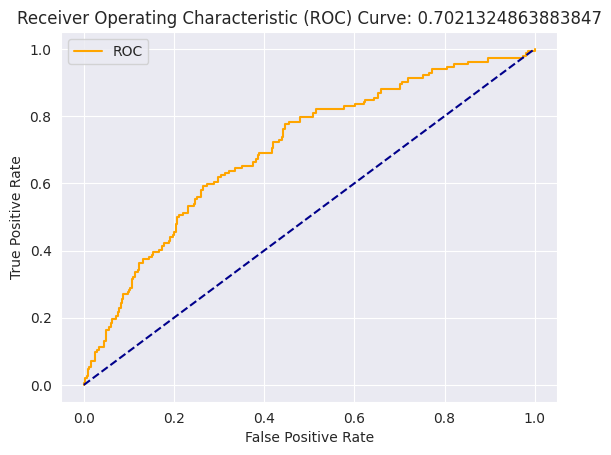

In [52]:
def plot_roc_curve(fpr, tpr,score):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve: '+str(score))
    plt.legend()
    plt.show()
    
true=[]
pred=[]
pred_acc=[]
for foldi in range(0,10):
        weightsdir=newdir+'/'+str(foldi)+'/'+str(tenfold[foldi]).replace('0.','')+'.h5'
        print(weightsdir)
        X_test = np.reshape(xfine[testindex[foldi]],(len(xfine[testindex[foldi]]),pixel,pixel,channels))
        model=tf.keras.models.load_model(weightsdir)
        true.extend(yfine[testindex[foldi]])
        pred.extend(model.predict(X_test)[:,0])
        pred_acc.append(accuracy_score(yfine[testindex[foldi]],np.where(model.predict(X_test)[:,0] >= 0.5, 1, 0)))


score=roc_auc_score(true, pred)
fpr, tpr, thresholds = roc_curve(true, pred)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
print("Threshold value is:", threshold)
plot_roc_curve(fpr, tpr,score)

In [53]:
print(pred_acc,np.mean(pred_acc))

[0.7291666666666666, 0.7021276595744681, 0.7021276595744681, 0.7021276595744681, 0.7659574468085106, 0.6382978723404256, 0.6595744680851063, 0.6595744680851063, 0.6382978723404256, 0.723404255319149] 0.6920656028368795


In [54]:
print(true,pred)

[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 